In [18]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

# Фиксируем seed для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)


Используемое устройство: cuda


In [19]:
# Гиперпараметры
BATCH_SIZE = 256
LEARNING_RATE = 0.0002
BETA1 = 0.5  # для Adam оптимизатора
NUM_EPOCHS = 50
LATENT_DIM = 100  # размерность латентного пространства
IMAGE_SIZE = 28
CHANNELS = 1

# Создание директории для сохранения результатов
os.makedirs('generated_images', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"Гиперпараметры:")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Latent Dimension: {LATENT_DIM}")


Гиперпараметры:
Batch Size: 256
Learning Rate: 0.0002
Epochs: 50
Latent Dimension: 100


Количество батчей в тренировочном наборе: 235
Общее количество изображений: 60000


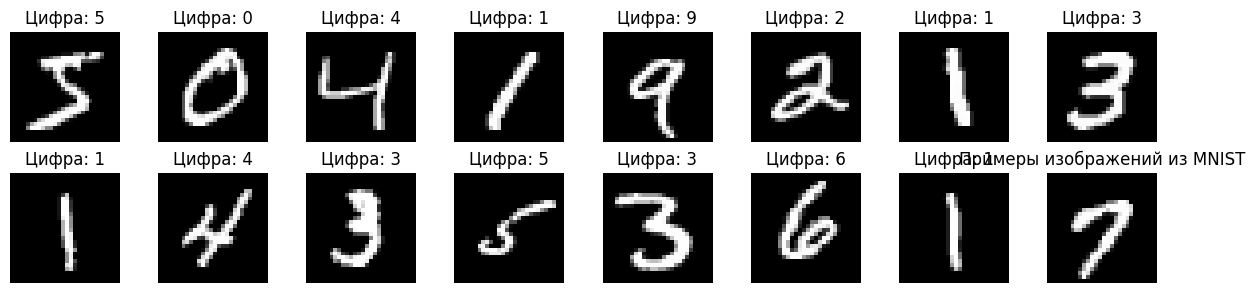

In [20]:
# Загрузка и предобработка данных MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # нормализация в диапазон [-1, 1]
])

# Загружаем датасет MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

print(f"Количество батчей в тренировочном наборе: {len(train_loader)}")
print(f"Общее количество изображений: {len(train_dataset)}")

# Визуализируем несколько примеров из датасета
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(16):
    img, label = train_dataset[i]
    axes[i//8, i%8].imshow(img.squeeze(), cmap='gray')
    axes[i//8, i%8].set_title(f'Цифра: {label}')
    axes[i//8, i%8].axis('off')
plt.tight_layout()
plt.title('Примеры изображений из MNIST')
plt.show()


In [21]:
# Определение архитектуры генератора
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()  # выход в диапазоне [-1, 1]
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Создаем генератор
generator = Generator(LATENT_DIM, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
print("Архитектура генератора:")
print(generator)


Архитектура генератора:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


In [22]:
# Определение архитектуры дискриминатора
class Discriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),  # добавляем dropout - ослабляем дискриминатор
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),  # добавляем dropout - ослабляем дискриминатор
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Создаем дискриминатор
discriminator = Discriminator((CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
print("Архитектура дискриминатора:")
print(discriminator)


Архитектура дискриминатора:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [23]:
# Функция потерь и оптимизаторы
adversarial_loss = nn.BCELoss()

# Оптимизаторы для генератора и дискриминатора
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

print("Настройка завершена!")
print(f"Функция потерь: {adversarial_loss}")
print(f"Оптимизатор генератора: Adam (lr={LEARNING_RATE}, beta1={BETA1})")
print(f"Оптимизатор дискриминатора: Adam (lr={LEARNING_RATE}, beta1={BETA1})")


Настройка завершена!
Функция потерь: BCELoss()
Оптимизатор генератора: Adam (lr=0.0002, beta1=0.5)
Оптимизатор дискриминатора: Adam (lr=0.0002, beta1=0.5)


In [24]:
# Вспомогательные функции для визуализации и сохранения

def save_generated_images(generator, epoch, num_images=64):
    """Генерация и сохранение изображений"""
    generator.eval()
    with torch.no_grad():
        # Генерируем случайный шум
        z = torch.randn(num_images, LATENT_DIM).to(device)
        # Генерируем изображения
        generated_imgs = generator(z)
        
        # Преобразуем для визуализации
        generated_imgs = generated_imgs.cpu().detach()
        
        # Создаем сетку изображений
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i in range(num_images):
            img = generated_imgs[i].squeeze()
            axes[i//8, i%8].imshow(img, cmap='gray')
            axes[i//8, i%8].axis('off')
        
        plt.suptitle(f'Сгенерированные изображения - Эпоха {epoch}')
        plt.tight_layout()
        plt.savefig(f'generated_images/epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    generator.train()

def plot_losses(g_losses, d_losses):
    """Построение графиков потерь"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Потери генератора', color='blue')
    plt.plot(d_losses, label='Потери дискриминатора', color='red')
    plt.xlabel('Итерация')
    plt.ylabel('Потери')
    plt.title('Потери во время обучения')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Скользящее среднее для сглаживания
    window = 50
    if len(g_losses) > window:
        g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
        d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
        plt.plot(g_smooth, label='Потери генератора (сгл.)', color='blue')
        plt.plot(d_smooth, label='Потери дискриминатора (сгл.)', color='red')
        plt.xlabel('Итерация')
        plt.ylabel('Потери (сглаженные)')
        plt.title('Сглаженные потери')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Вспомогательные функции определены!")


Вспомогательные функции определены!


Сгенерированные изображения до обучения:


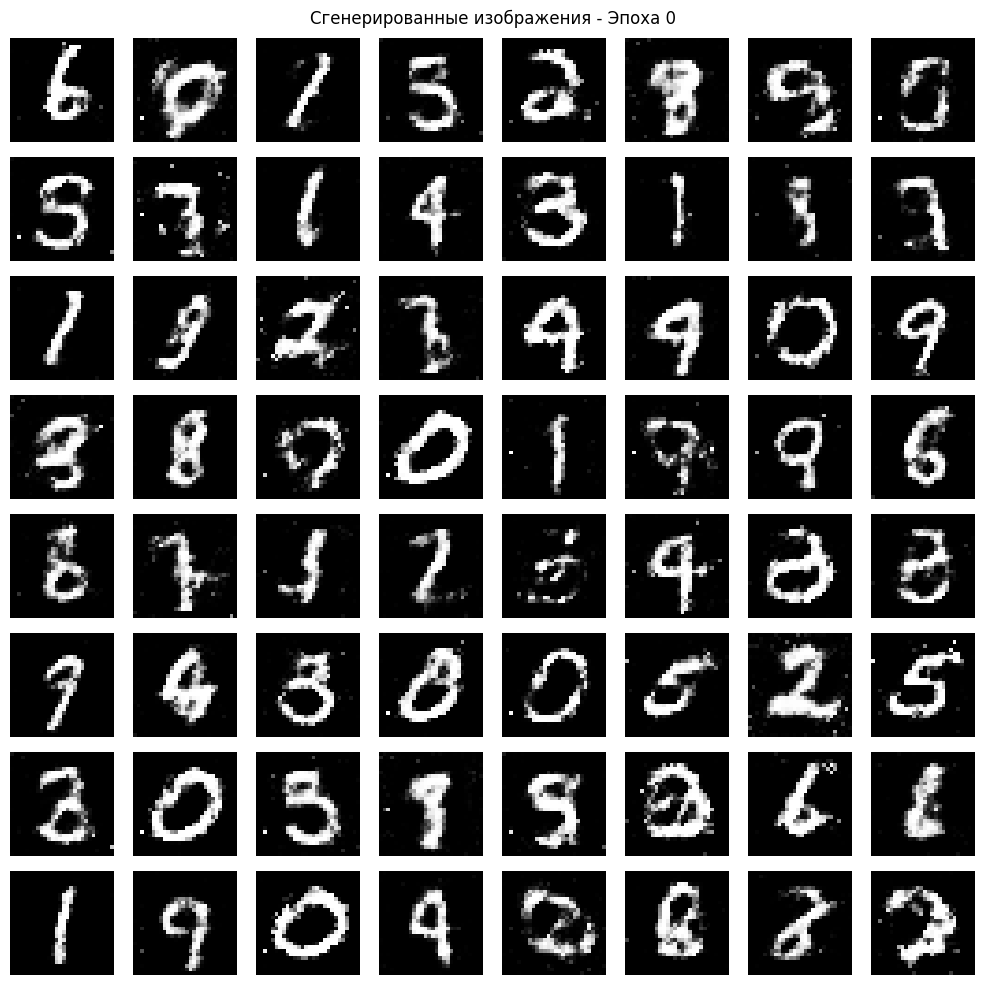

In [30]:
# Процесс обучения GAN
def train_gan():
    G_losses = []
    D_losses = []
    
    print("Начинаем обучение GAN...")
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        # Прогресс-бар для текущей эпохи
        pbar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{NUM_EPOCHS}')
        
        for i, (real_imgs, _) in enumerate(pbar):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # Метки для настоящих и поддельных изображений
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # ---------------------
            # Обучение дискриминатора
            # ---------------------
            optimizer_D.zero_grad()
            
            # Потери на настоящих изображениях
            real_output = discriminator(real_imgs)
            real_loss = adversarial_loss(real_output, real_labels)
            
            # Генерация поддельных изображений
            z = torch.randn(batch_size, LATENT_DIM).to(device)
            fake_imgs = generator(z)
            
            # Потери на поддельных изображениях
            fake_output = discriminator(fake_imgs.detach())
            fake_loss = adversarial_loss(fake_output, fake_labels)
            
            # Общие потери дискриминатора
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Обучение генератора
            # ---------------------
            optimizer_G.zero_grad()
            
            # Генератор пытается обмануть дискриминатор
            fake_output = discriminator(fake_imgs)
            g_loss = adversarial_loss(fake_output, real_labels)  # хотим, чтобы fake_output было близко к 1
            
            g_loss.backward()
            optimizer_G.step()
            
            # Сохраняем потери для статистики
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            # Обновляем прогресс-бар
            pbar.set_postfix({
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}'
            })
        
        # Средние потери за эпоху
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        
        print(f'Эпоха [{epoch+1}/{NUM_EPOCHS}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}')
        
        # Сохраняем сгенерированные изображения каждые 10 эпох
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch + 1)
        
        # Сохраняем модели каждые 25 эпох
        if (epoch + 1) % 25 == 0:
            torch.save(generator.state_dict(), f'models/generator_epoch_{epoch+1}.pth')
            torch.save(discriminator.state_dict(), f'models/discriminator_epoch_{epoch+1}.pth')
    
    return G_losses, D_losses

# Генерируем начальные изображения (до обучения)
print("Сгенерированные изображения до обучения:")
save_generated_images(generator, 0)


Начинаем обучение GAN...


Эпоха 1/50: 100%|█| 235/235 [00:07<00:00, 29.46


Эпоха [1/50] - D_loss: 0.6081, G_loss: 0.8011


Эпоха 2/50: 100%|█| 235/235 [00:07<00:00, 29.79


Эпоха [2/50] - D_loss: 0.6058, G_loss: 1.0099


Эпоха 3/50: 100%|█| 235/235 [00:07<00:00, 29.83


Эпоха [3/50] - D_loss: 0.5898, G_loss: 1.1039


Эпоха 4/50: 100%|█| 235/235 [00:07<00:00, 29.88


Эпоха [4/50] - D_loss: 0.5831, G_loss: 1.1323


Эпоха 5/50: 100%|█| 235/235 [00:07<00:00, 29.77


Эпоха [5/50] - D_loss: 0.5753, G_loss: 1.1830


Эпоха 6/50: 100%|█| 235/235 [00:07<00:00, 29.57


Эпоха [6/50] - D_loss: 0.5660, G_loss: 1.2222


Эпоха 7/50: 100%|█| 235/235 [00:07<00:00, 29.95


Эпоха [7/50] - D_loss: 0.5611, G_loss: 1.2222


Эпоха 8/50: 100%|█| 235/235 [00:07<00:00, 29.87


Эпоха [8/50] - D_loss: 0.5725, G_loss: 1.1809


Эпоха 9/50: 100%|█| 235/235 [00:07<00:00, 30.26


Эпоха [9/50] - D_loss: 0.5649, G_loss: 1.1905


Эпоха 10/50: 100%|█| 235/235 [00:07<00:00, 30.2


Эпоха [10/50] - D_loss: 0.5608, G_loss: 1.2037


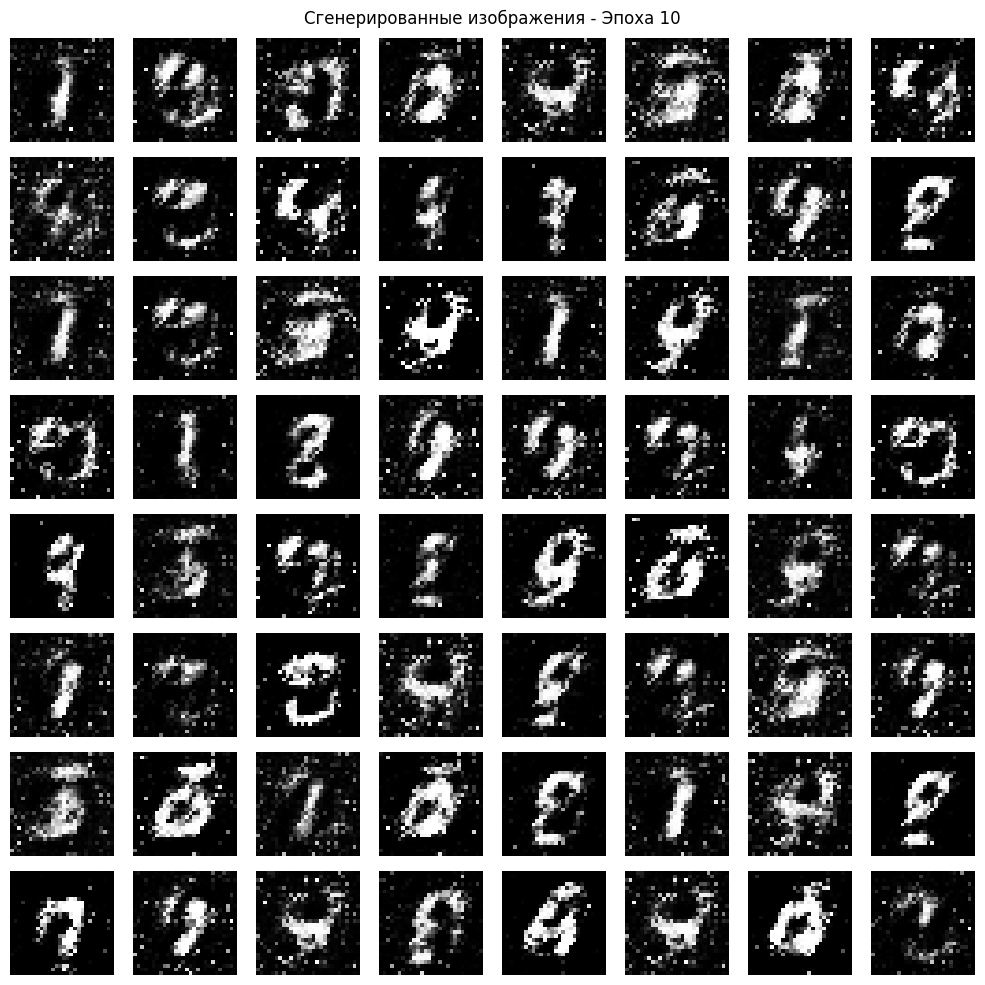

Эпоха 11/50: 100%|█| 235/235 [00:07<00:00, 29.6


Эпоха [11/50] - D_loss: 0.5596, G_loss: 1.1928


Эпоха 12/50: 100%|█| 235/235 [00:07<00:00, 29.7


Эпоха [12/50] - D_loss: 0.5614, G_loss: 1.1681


Эпоха 13/50: 100%|█| 235/235 [00:07<00:00, 29.4


Эпоха [13/50] - D_loss: 0.5657, G_loss: 1.1554


Эпоха 14/50: 100%|█| 235/235 [00:07<00:00, 29.4


Эпоха [14/50] - D_loss: 0.5698, G_loss: 1.1293


Эпоха 15/50: 100%|█| 235/235 [00:07<00:00, 29.4


Эпоха [15/50] - D_loss: 0.5795, G_loss: 1.0828


Эпоха 16/50: 100%|█| 235/235 [00:07<00:00, 29.5


Эпоха [16/50] - D_loss: 0.5823, G_loss: 1.0712


Эпоха 17/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [17/50] - D_loss: 0.5785, G_loss: 1.0648


Эпоха 18/50: 100%|█| 235/235 [00:07<00:00, 29.5


Эпоха [18/50] - D_loss: 0.5806, G_loss: 1.0597


Эпоха 19/50: 100%|█| 235/235 [00:07<00:00, 29.6


Эпоха [19/50] - D_loss: 0.5906, G_loss: 1.0262


Эпоха 20/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [20/50] - D_loss: 0.5851, G_loss: 1.0427


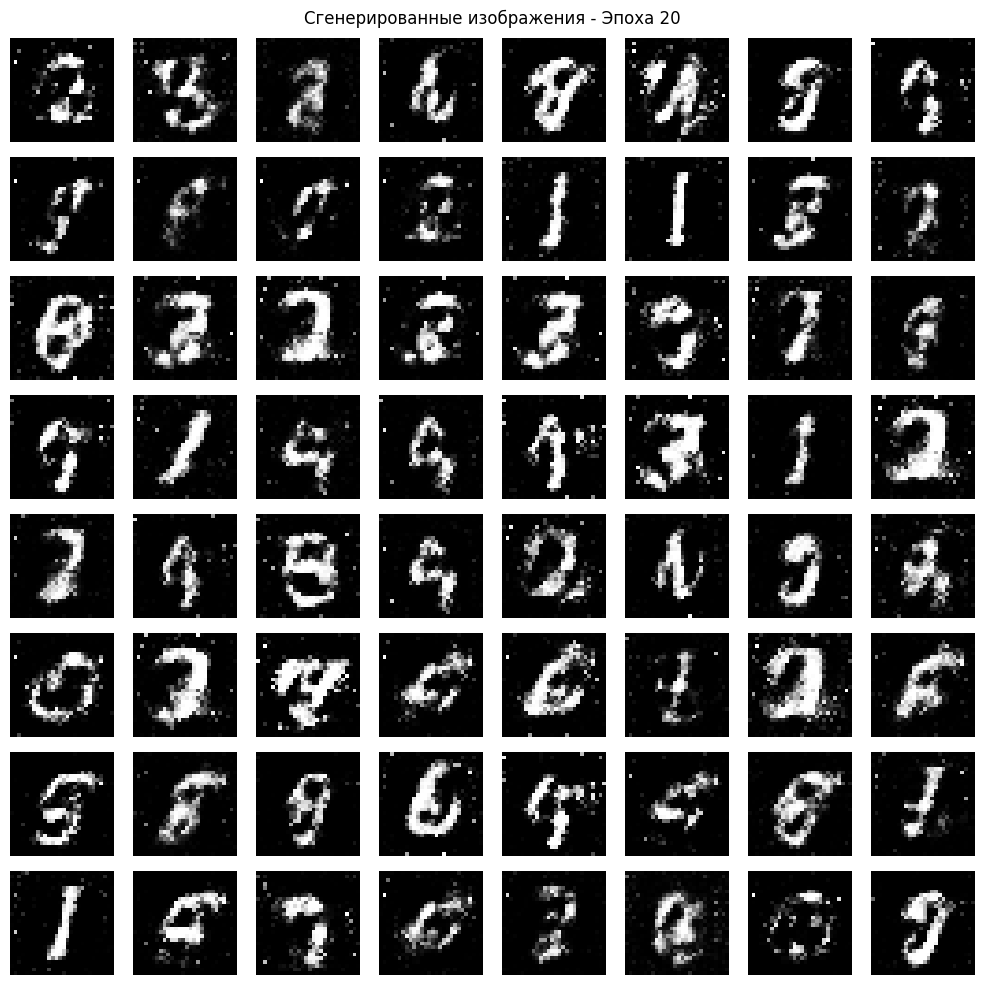

Эпоха 21/50: 100%|█| 235/235 [00:07<00:00, 29.7


Эпоха [21/50] - D_loss: 0.5920, G_loss: 1.0213


Эпоха 22/50: 100%|█| 235/235 [00:07<00:00, 29.8


Эпоха [22/50] - D_loss: 0.5946, G_loss: 1.0028


Эпоха 23/50: 100%|█| 235/235 [00:07<00:00, 29.6


Эпоха [23/50] - D_loss: 0.6017, G_loss: 0.9869


Эпоха 24/50: 100%|█| 235/235 [00:07<00:00, 29.6


Эпоха [24/50] - D_loss: 0.6046, G_loss: 0.9687


Эпоха 25/50: 100%|█| 235/235 [00:07<00:00, 29.5


Эпоха [25/50] - D_loss: 0.6052, G_loss: 0.9632


Эпоха 26/50: 100%|█| 235/235 [00:07<00:00, 29.4


Эпоха [26/50] - D_loss: 0.6063, G_loss: 0.9674


Эпоха 27/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [27/50] - D_loss: 0.6126, G_loss: 0.9462


Эпоха 28/50: 100%|█| 235/235 [00:07<00:00, 30.3


Эпоха [28/50] - D_loss: 0.6172, G_loss: 0.9368


Эпоха 29/50: 100%|█| 235/235 [00:07<00:00, 29.8


Эпоха [29/50] - D_loss: 0.6145, G_loss: 0.9363


Эпоха 30/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [30/50] - D_loss: 0.6158, G_loss: 0.9362


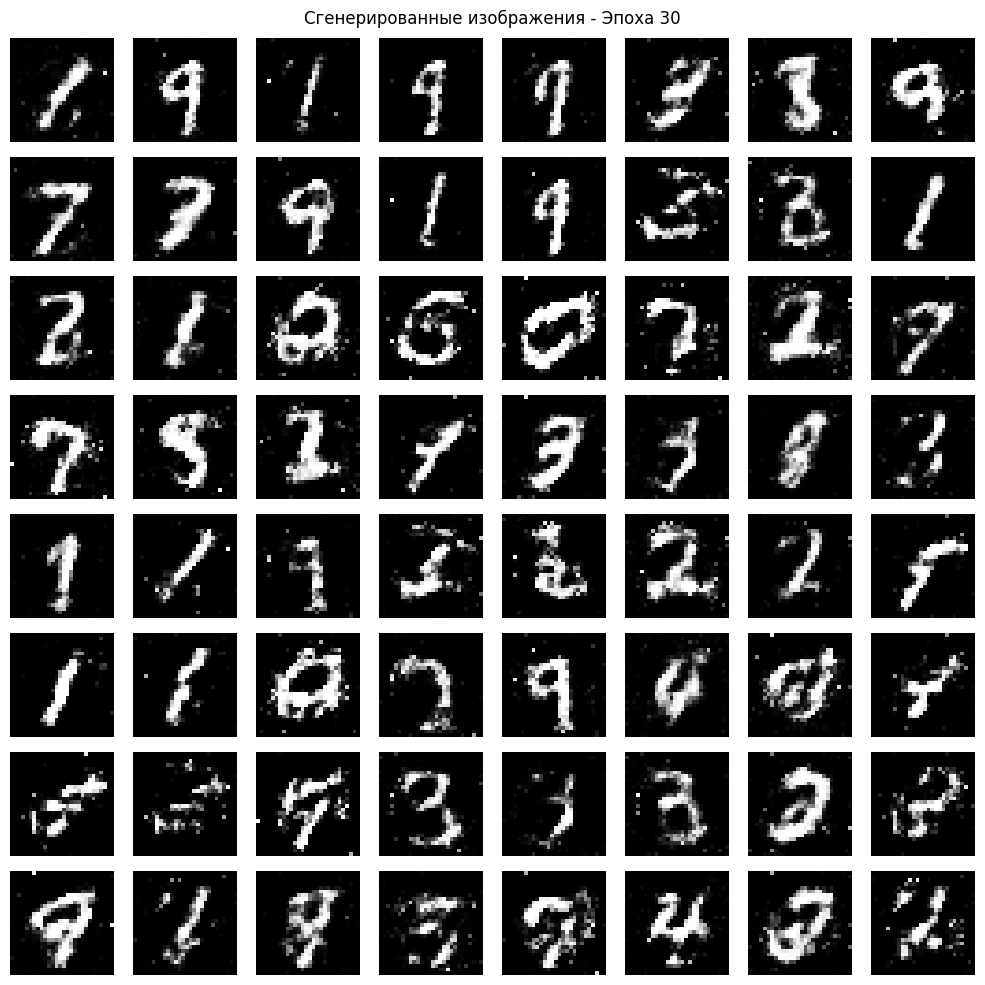

Эпоха 31/50: 100%|█| 235/235 [00:07<00:00, 30.1


Эпоха [31/50] - D_loss: 0.6234, G_loss: 0.9186


Эпоха 32/50: 100%|█| 235/235 [00:07<00:00, 29.5


Эпоха [32/50] - D_loss: 0.6242, G_loss: 0.9133


Эпоха 33/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [33/50] - D_loss: 0.6240, G_loss: 0.9110


Эпоха 34/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [34/50] - D_loss: 0.6274, G_loss: 0.9029


Эпоха 35/50: 100%|█| 235/235 [00:07<00:00, 29.8


Эпоха [35/50] - D_loss: 0.6296, G_loss: 0.8991


Эпоха 36/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [36/50] - D_loss: 0.6335, G_loss: 0.8914


Эпоха 37/50: 100%|█| 235/235 [00:07<00:00, 30.1


Эпоха [37/50] - D_loss: 0.6341, G_loss: 0.8815


Эпоха 38/50: 100%|█| 235/235 [00:07<00:00, 30.2


Эпоха [38/50] - D_loss: 0.6378, G_loss: 0.8784


Эпоха 39/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [39/50] - D_loss: 0.6374, G_loss: 0.8773


Эпоха 40/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [40/50] - D_loss: 0.6399, G_loss: 0.8692


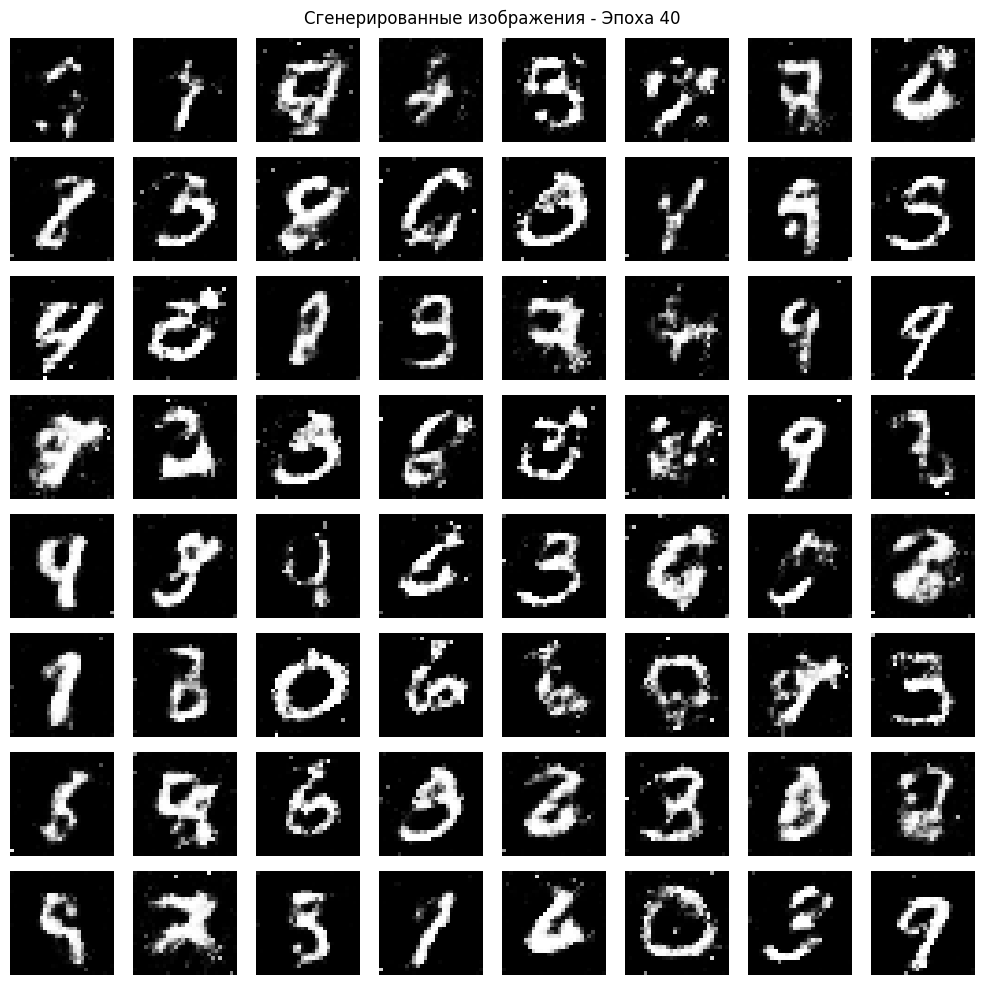

Эпоха 41/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [41/50] - D_loss: 0.6414, G_loss: 0.8686


Эпоха 42/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [42/50] - D_loss: 0.6425, G_loss: 0.8651


Эпоха 43/50: 100%|█| 235/235 [00:07<00:00, 30.1


Эпоха [43/50] - D_loss: 0.6446, G_loss: 0.8573


Эпоха 44/50: 100%|█| 235/235 [00:07<00:00, 30.1


Эпоха [44/50] - D_loss: 0.6460, G_loss: 0.8575


Эпоха 45/50: 100%|█| 235/235 [00:07<00:00, 30.0


Эпоха [45/50] - D_loss: 0.6493, G_loss: 0.8448


Эпоха 46/50: 100%|█| 235/235 [00:07<00:00, 29.7


Эпоха [46/50] - D_loss: 0.6511, G_loss: 0.8422


Эпоха 47/50: 100%|█| 235/235 [00:07<00:00, 29.6


Эпоха [47/50] - D_loss: 0.6517, G_loss: 0.8397


Эпоха 48/50: 100%|█| 235/235 [00:07<00:00, 29.7


Эпоха [48/50] - D_loss: 0.6548, G_loss: 0.8346


Эпоха 49/50: 100%|█| 235/235 [00:07<00:00, 29.8


Эпоха [49/50] - D_loss: 0.6549, G_loss: 0.8251


Эпоха 50/50: 100%|█| 235/235 [00:07<00:00, 29.9


Эпоха [50/50] - D_loss: 0.6560, G_loss: 0.8279


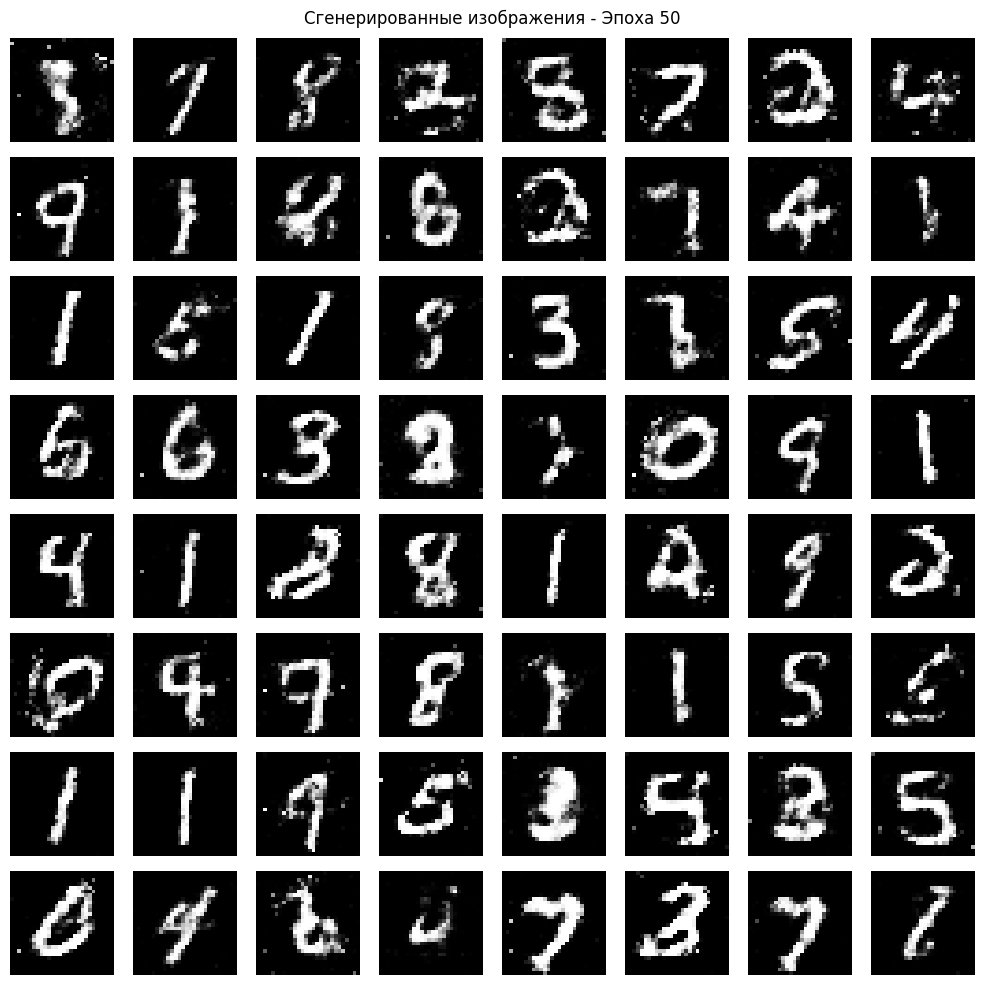

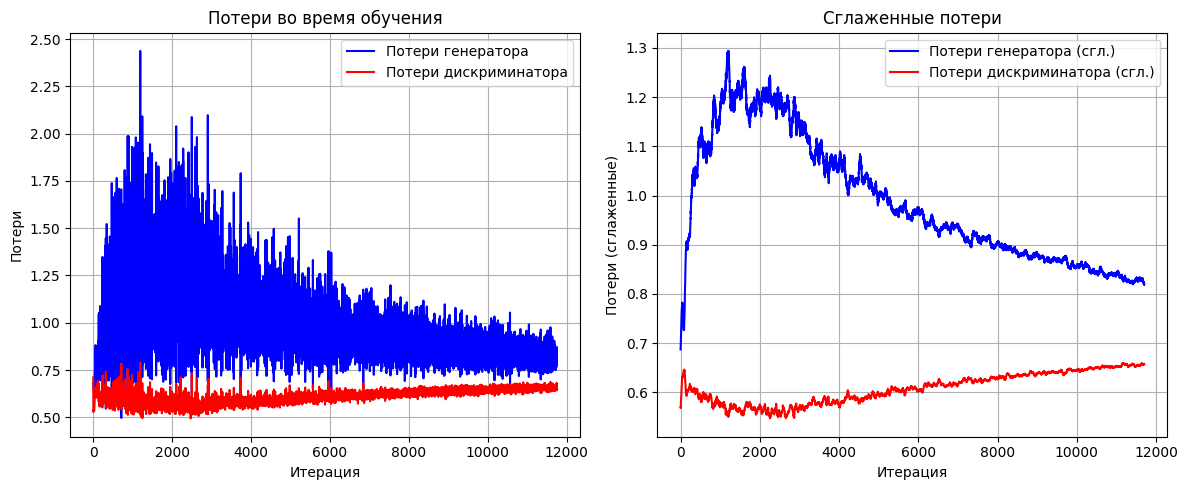

Финальные сгенерированные изображения:


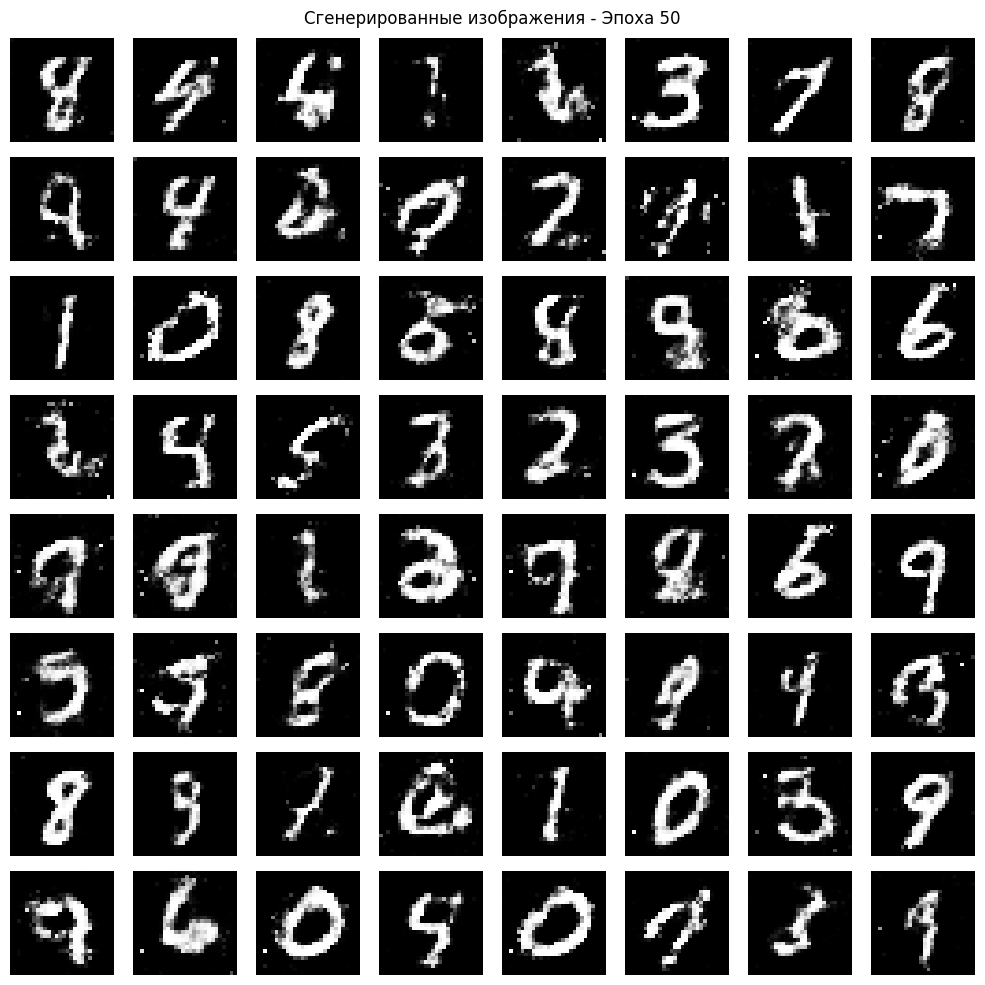

Модели сохранены!


In [26]:
# Запускаем обучение
G_losses, D_losses = train_gan()

# Построение графиков потерь
plot_losses(G_losses, D_losses)

# Сохраняение финальных изображений
print("Финальные сгенерированные изображения:")
save_generated_images(generator, NUM_EPOCHS)

# Сохраняем финальные модели
torch.save(generator.state_dict(), 'models/generator_final.pth')
torch.save(discriminator.state_dict(), 'models/discriminator_final.pth')
print("Модели сохранены!")


In [28]:
# Экспериментирование с различными архитектурами

# Версия 2: Улучшенный генератор с Dropout
class ImprovedGenerator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(ImprovedGenerator, self).__init__()
        self.img_shape = img_shape
        
        def block(in_feat, out_feat, normalize=True, dropout=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                layers.append(nn.Dropout(0.3))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 256, normalize=False),
            *block(256, 512, dropout=True),
            *block(512, 1024, dropout=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Версия 2: Улучшенный дискриминатор с Dropout
class ImprovedDiscriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(ImprovedDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

print("Улучшенные архитектуры определены!")
print("Можете поэкспериментировать с разными архитектурами, заменив исходные модели.")


Улучшенные архитектуры определены!
Можете поэкспериментировать с разными архитектурами, заменив исходные модели.


Сравнение моделей:


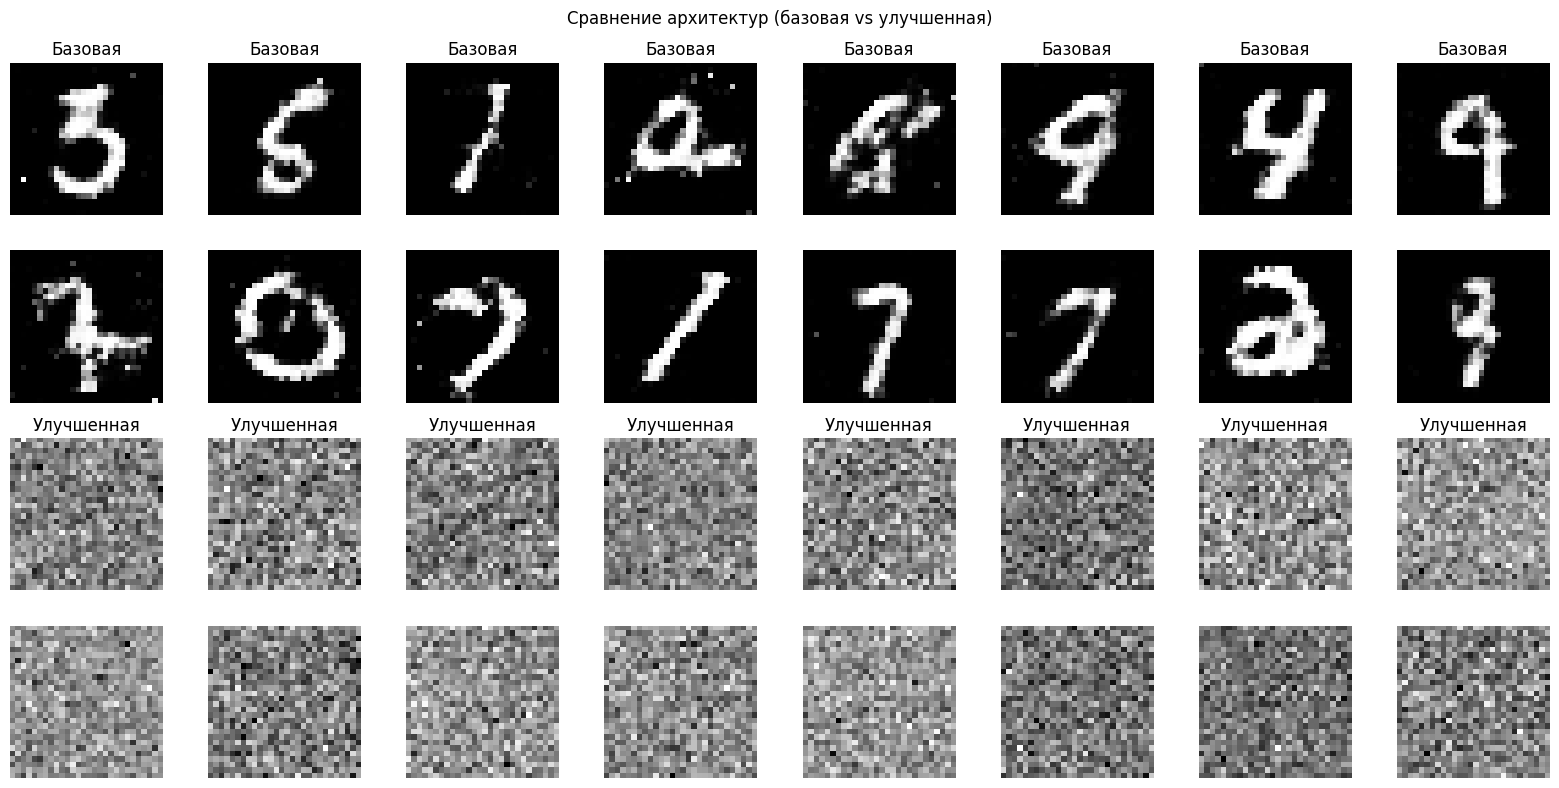


Анализ гиперпараметров:
Рекомендации по гиперпараметрам:
1. Learning Rate: 0.0002 - хороший баланс между скоростью и стабильностью
2. Latent Dimension: 100 - достаточно для MNIST, больше для сложных данных
3. Batch Size: 256 - компромисс между памятью и качеством градиентов
4. Beta1 (Adam): 0.8 - меньше стандартного 0.9 для лучшей стабильности GAN


In [31]:
# Функция для сравнения моделей
def compare_models():
    """Сравнение производительности разных архитектур"""
    
    # Создаем тестовый шум
    test_noise = torch.randn(16, LATENT_DIM).to(device)
    
    # Генерируем изображения базовой моделью
    with torch.no_grad():
        basic_imgs = generator(test_noise).cpu()
    
    # Создаем улучшенную модель (для демонстрации)
    improved_gen = ImprovedGenerator(LATENT_DIM, (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(device)
    
    # Генерируем изображения улучшенной моделью (случайные веса)
    with torch.no_grad():
        improved_imgs = improved_gen(test_noise).cpu()
    
    # Визуализация сравнения
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    
    for i in range(16):
        # Базовая модель (верхние два ряда)
        axes[0 if i < 8 else 1, i % 8].imshow(basic_imgs[i].squeeze(), cmap='gray')
        axes[0 if i < 8 else 1, i % 8].set_title('Базовая' if i < 8 else '')
        axes[0 if i < 8 else 1, i % 8].axis('off')
        
        # Улучшенная модель (нижние два ряда)
        axes[2 if i < 8 else 3, i % 8].imshow(improved_imgs[i].squeeze(), cmap='gray')
        axes[2 if i < 8 else 3, i % 8].set_title('Улучшенная' if i < 8 else '')
        axes[2 if i < 8 else 3, i % 8].axis('off')
    
    plt.suptitle('Сравнение архитектур (базовая vs улучшенная)')
    plt.tight_layout()
    plt.show()

# Функция для анализа гиперпараметров
def hyperparameter_analysis():
    """Анализ влияния различных гиперпараметров"""
    
    hyperparams = {
        'learning_rates': [0.0001, 0.0002, 0.0005],
        'latent_dims': [50, 100, 200],
        'batch_sizes': [64, 128, 256]
    }
    
    print("Рекомендации по гиперпараметрам:")
    print("1. Learning Rate: 0.0002 - хороший баланс между скоростью и стабильностью")
    print("2. Latent Dimension: 100 - достаточно для MNIST, больше для сложных данных")
    print("3. Batch Size: 256 - компромисс между памятью и качеством градиентов")
    print("4. Beta1 (Adam): 0.8 - меньше стандартного 0.9 для лучшей стабильности GAN")
    
    return hyperparams

# Выполняем сравнение
print("Сравнение моделей:")
compare_models()

print("\nАнализ гиперпараметров:")
params = hyperparameter_analysis()
